In [7]:
import numpy as np

# Chemical Drawing
from rdkit.Chem import MolFromMolBlock, MolToMolFile, MolToMolBlock, AddHs
from rdkit import Chem
from rdkit.Chem.AllChem import Compute2DCoords
from rdkit.Chem.Draw import MolToImage
from IPython.display import display

# Lignin-KMC functions and global variables used in this notebook
from ligninkmc.kmc_functions import (run_kmc, generate_mol)
from ligninkmc.create_lignin import (calc_rates, create_initial_monomers, create_initial_events,
                                     create_initial_state, analyze_adj_matrix, adj_analysis_to_stdout)
from ligninkmc.kmc_common import (DEF_E_BARRIER_KCAL_MOL, ADJ_MATRIX, MONO_LIST, MONOMER, OX, GROW, Monomer, Event)

### Lignin with guaiacyl monomers only

In [8]:
# change the 3 vars below
save_dir = "/home/tgog/conformer-ml/lignins_out"
num_monos = [2, 4, 6, 8, 10]
lignin_oligomers = []

# Calculate the rates of reaction in 1/s (or 1/monomer-s if biomolecular) at the specified temp
temp = 298.15  # K
rxn_rates = calc_rates(temp, ea_kcal_mol_dict=DEF_E_BARRIER_KCAL_MOL)

In [9]:
for n in num_monos:
    # Set the percentage of S
    sg_ratio = 0
    pct_s = sg_ratio / (1 + sg_ratio)

    # Set the initial and maximum number of monomers to be modeled.
    ini_num_monos = 1
    max_num_monos = n

    # Maximum time to simulate, in seconds
    t_max = 1  # seconds
    mono_add_rate = 1e4  # monomers/second

    # Use a random number and the given sg_ratio to determine the monolignol types to be initially modeled
    monomer_draw = np.random.rand(ini_num_monos)
    initial_monomers = create_initial_monomers(pct_s, monomer_draw)

    # Initially allow only oxidation events. After they are used to determine the initial state, add 
    #     GROW to the events, which allows additional monomers to be added to the reaction at the 
    #     specified rate and with the specified ratio
    initial_events = create_initial_events(initial_monomers, rxn_rates)
    initial_state = create_initial_state(initial_events, initial_monomers)
    initial_events.append(Event(GROW, [], rate=mono_add_rate))

    # simulate lignin creation
    result = run_kmc(rxn_rates, initial_state,initial_events, n_max=max_num_monos, t_max=t_max, sg_ratio=sg_ratio)
    # using RDKit
    nodes = result[MONO_LIST]
    adj = result[ADJ_MATRIX]
    block = generate_mol(adj, nodes)
    mol = MolFromMolBlock(block)
#     # cap with hydrogens
#     mol = AddHs(mol)
    lignin_oligomers.append(mol)
    # save
    fn = save_dir + f"/{sg_ratio}sgr_{max_num_monos}monos.mol"
    MolToMolFile(mol, fn)

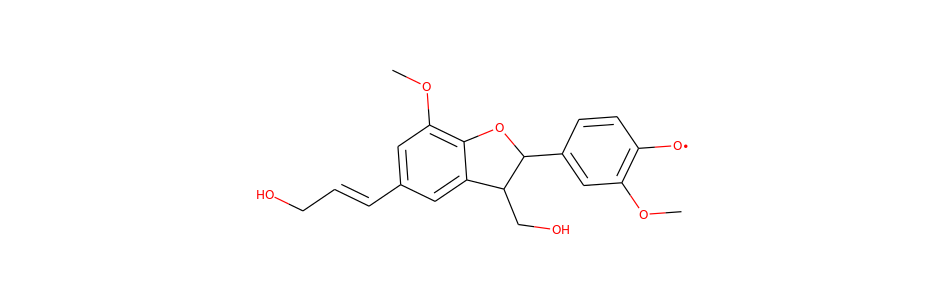

In [26]:
# display 2D
mol = lignin_oligomers[0]
Compute2DCoords(mol)
display(MolToImage(mol, size=(950, 300)))

In [27]:
Chem.AllChem.EmbedMultipleConfs(mol, numConfs=1, numThreads=-1)
Chem.AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)

[(0, 84.77857065145203)]

In [28]:
import py3Dmol
def drawit(m, p, confId=-1):
    mb = MolToMolBlock(m, confId=confId)
    p.removeAllModels()
    p.addModel(mb, "sdf")
    p.setStyle({"stick":{}})
    p.setBackgroundColor("0xeeeeee")
    p.zoomTo()
    return p.show()

p = py3Dmol.view(width=800,height=800)
drawit(mol, p, confId=0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

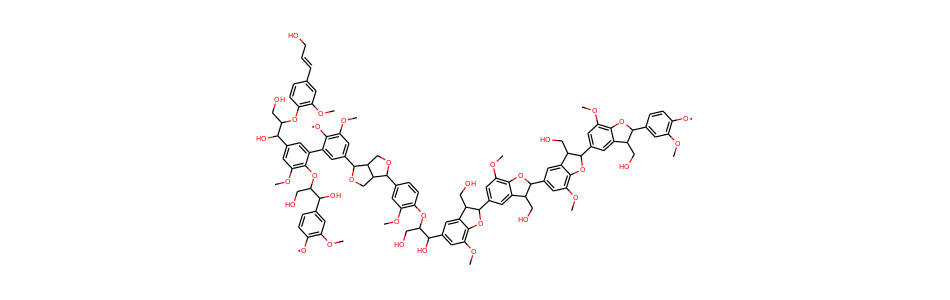

In [30]:
# display 2D
mol = lignin_oligomers[-1]
Compute2DCoords(mol)
display(MolToImage(mol, size=(950, 300)))

In [32]:
Chem.AllChem.EmbedMultipleConfs(mol, numConfs=1, numThreads=-1)
Chem.AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)
drawit(mol, p, confId=0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [20]:
conf = mol.GetConformers()[0]

In [23]:
conf.GetAtomPosition(0).x

-14.633322050588758